In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
url_amazon = "https://www.dropbox.com/scl/fi/buumu20kudhg2zdts2i3b/amz_uk_price_prediction_dataset.csv?rlkey=r3orul9oyz4u92ocong8crggo&st=zusc0jxb&dl=1"
amazon = pd.read_csv(url_amazon, delimiter=',', on_bad_lines='skip')
print(amazon.columns)
amazon.head()

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category.
Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [24]:
amazon = amazon[amazon.columns[amazon.isnull().mean() < 0.8]]


In [25]:
crosstab_result = pd.crosstab(amazon['category'], amazon['isBestSeller'])
print(crosstab_result.columns)
crosstab_result.info()

Index([False, True], dtype='bool', name='isBestSeller')
<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 3D Printers to eBook Readers & Accessories
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   False   296 non-null    int64
 1   True    296 non-null    int64
dtypes: int64(2)
memory usage: 6.9+ KB


In [26]:
# Calculate the proportion of best-sellers for each category
crosstab_result.rename(columns={0: 'no_BS', 1: 'yes_BS'}, inplace=True)
crosstab_result['bs_category'] = crosstab_result['yes_BS'] / (crosstab_result['no_BS'] + crosstab_result['yes_BS'])

# Sort the DataFrame based on the bs_category column in descending order
crosstab_result_sorted = crosstab_result.sort_values(by='bs_category', ascending=False)
crosstab_result_sorted

isBestSeller,no_BS,yes_BS,bs_category
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


In [27]:
from scipy.stats import chi2_contingency

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value
# <0.05 so that theres is evidence that theres a correlation between category and best seller

(36684.23786636857, 0.0)

In [28]:
# Assuming crosstab_result is a DataFrame
print(crosstab_result.dtypes)
print(crosstab_result)
crosstab_result_int = crosstab_result.astype(int)

from scipy.stats.contingency import association

# Computing the association between variables using the "cramer" method
cramer_v = association(crosstab_result_int, method="cramer")
print(cramer_v)


isBestSeller
no_BS            int64
yes_BS           int64
bs_category    float64
dtype: object
isBestSeller                    no_BS  yes_BS  bs_category
category                                                  
3D Printers                       247       1     0.004032
3D Printing & Scanning           4065       2     0.000492
Abrasive & Finishing Products     245       5     0.020000
Action Cameras                   1696       1     0.000589
Adapters                          251       3     0.011811
...                               ...     ...          ...
Wind Instruments                  243       7     0.028000
Window Treatments                 234       5     0.020921
Women                           17559     213     0.011985
Women's Sports & Outdoor Shoes   1939      20     0.010209
eBook Readers & Accessories       246       0     0.000000

[296 rows x 3 columns]


ValueError: The internally computed table of expected frequencies has a zero element at (0, 2).

<Axes: xlabel='category'>

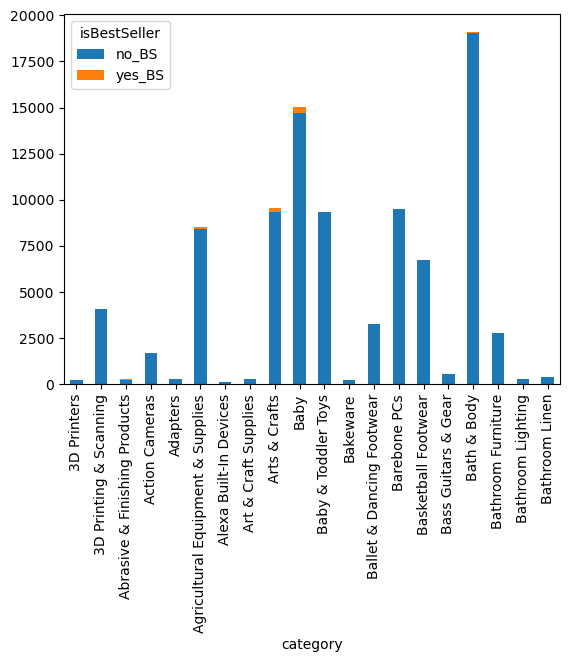

In [34]:
top_5_categories_crosstab = crosstab_result.head(20)
top_5_categories_crosstab = top_5_categories_crosstab.drop(columns=['bs_category'])
top_5_categories_crosstab.plot(kind="bar", stacked=True)

Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.
Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.
Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [35]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers


In [37]:
data_series = amazon['price']  # replace 'ColumnName' with your specific column
outliers = tukeys_test_outliers(data_series)
# Filter out the outliers to create a cleaned DataFrame
cleaned_data = amazon[~amazon['price'].isin(outliers)]
cleaned_data

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category,bs_category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers,0.001372
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers,0.001372
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers,0.001372
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers,0.001372
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers,0.001372
...,...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing,0.018595
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing,0.018595
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing,0.018595
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing,0.018595


/var/folders/cs/y9j221r92lb_hk6mpd7ppm0c0000gn/T/ipykernel_86018/1996594003.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_data, x='price', y='category', palette="coolwarm")


<Axes: xlabel='price', ylabel='category'>

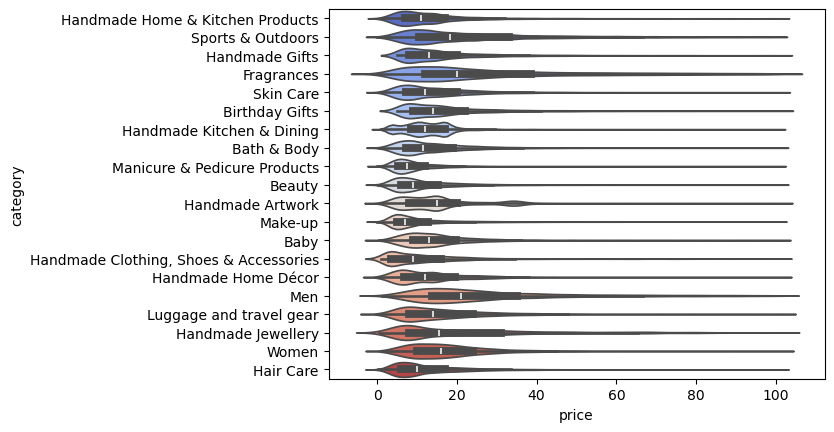

In [46]:
# Calculate the proportion table of categories
proportion_table = cleaned_data['category'].value_counts(normalize=True)

# Get the top 20 categories
top_20_categories = proportion_table.head(20).index

# Filter the cleaned DataFrame to include only the top 20 categories
filtered_data = cleaned_data[cleaned_data['category'].isin(top_20_categories)]

sns.violinplot(data=filtered_data, x='price', y='category', palette="coolwarm")


/var/folders/cs/y9j221r92lb_hk6mpd7ppm0c0000gn/T/ipykernel_86018/1511548246.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_prices, x='price', y='category', palette="coolwarm")


<Axes: xlabel='price', ylabel='category'>

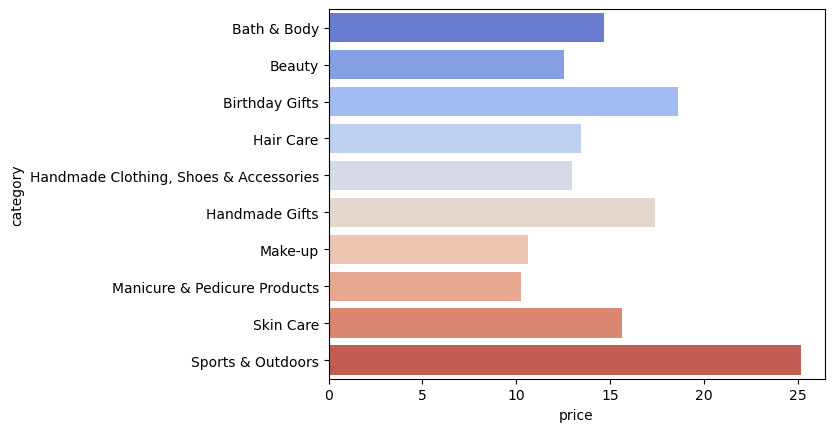

In [51]:
# Which product category tends to have the highest median price? Don't filter here by top categories.
# -> Men Categories
# Get the top 10 count categories
top_10_categories = proportion_table.head(10).index
# Filter the cleaned DataFrame to include only the top 20 categories
filtered_data_2 = cleaned_data[cleaned_data['category'].isin(top_10_categories)]
average_prices = filtered_data_2.groupby('category')['price'].mean().reset_index()
sns.barplot(data=average_prices, x='price', y='category', palette="coolwarm")


/var/folders/cs/y9j221r92lb_hk6mpd7ppm0c0000gn/T/ipykernel_86018/3674263473.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='stars', y='category', palette="coolwarm")


<Axes: xlabel='stars', ylabel='category'>

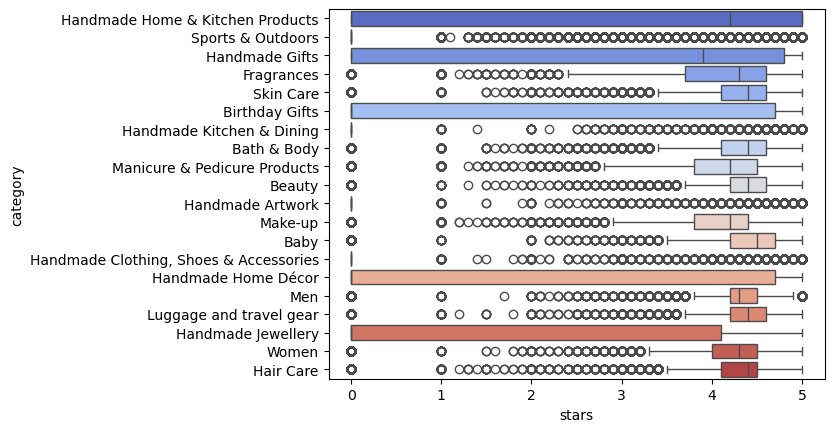

In [71]:
sns.boxplot(data=filtered_data, x='stars', y='category', palette="coolwarm")


/var/folders/cs/y9j221r92lb_hk6mpd7ppm0c0000gn/T/ipykernel_86018/4103025465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='stars', y='category', palette="coolwarm")


<Axes: xlabel='stars', ylabel='category'>

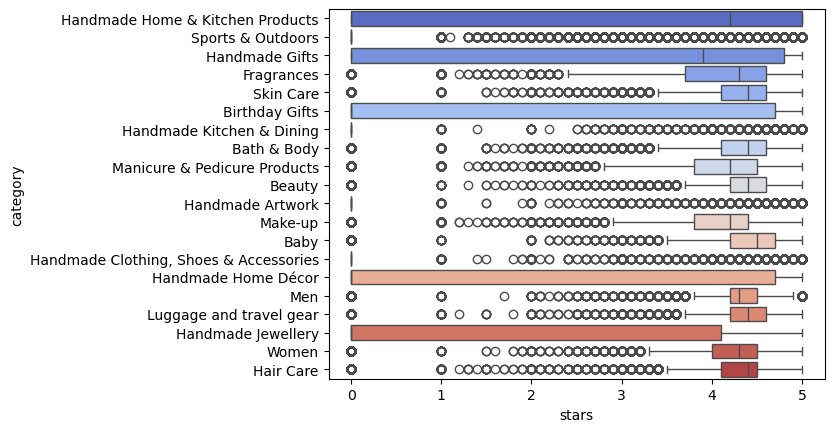

In [79]:
# Highest average price --> Sport&Outdoors
sns.boxplot(data=filtered_data, x='stars', y='category', palette="coolwarm")
# sns.violinplot(data=filtered_data, x='stars', y='category', palette="coolwarm")


# Best median rating -> Baby category
Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?
Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.


In [77]:
filtered_data.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category,bs_category
19513,21072,B09477KHQ3,"Personalised Birthday Print Gift ""THE YEAR YOU...",4.5,763,7.99,False,900,Handmade Home & Kitchen Products,0.002753
19514,21073,B0BSRFQYG8,Wax Melts 4 Bars | Build Your Own Box (Choose ...,3.9,117,6.49,True,800,Handmade Home & Kitchen Products,0.002753
19515,21074,B09N9GVHV9,"Personalised Birthday Print Gift ""ON THE DAY/Y...",4.6,1155,8.99,True,600,Handmade Home & Kitchen Products,0.002753
19516,21075,B0BRYGV7PQ,Fresh Wax Melts - Laundry Type Wax Melts - Str...,4.5,56,4.99,True,500,Handmade Home & Kitchen Products,0.002753
19517,21076,B0B1JHB28R,Manta Makes Work Leaving Gifts | I Used to Wor...,4.7,261,9.95,True,400,Handmade Home & Kitchen Products,0.002753


In [68]:
correlation = filtered_data['stars'].corr(filtered_data['price'])
correlation2 = filtered_data['stars'].corr(filtered_data['price'], method='spearman')
correlation, correlation2

(-0.018068603878472523, -0.0168825662418409)

<Axes: xlabel='stars', ylabel='price'>

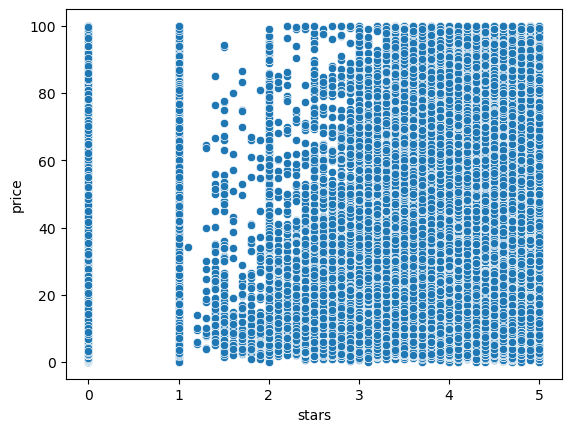

In [69]:
# (-0.018068603878472523, -0.0168825662418409) both close 0 -> low strength of association
# Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
# as stars tends to go up from the 1 mark, prices starts increasing as the stars go up
sns.scatterplot(data=filtered_data, x='stars', y='price')


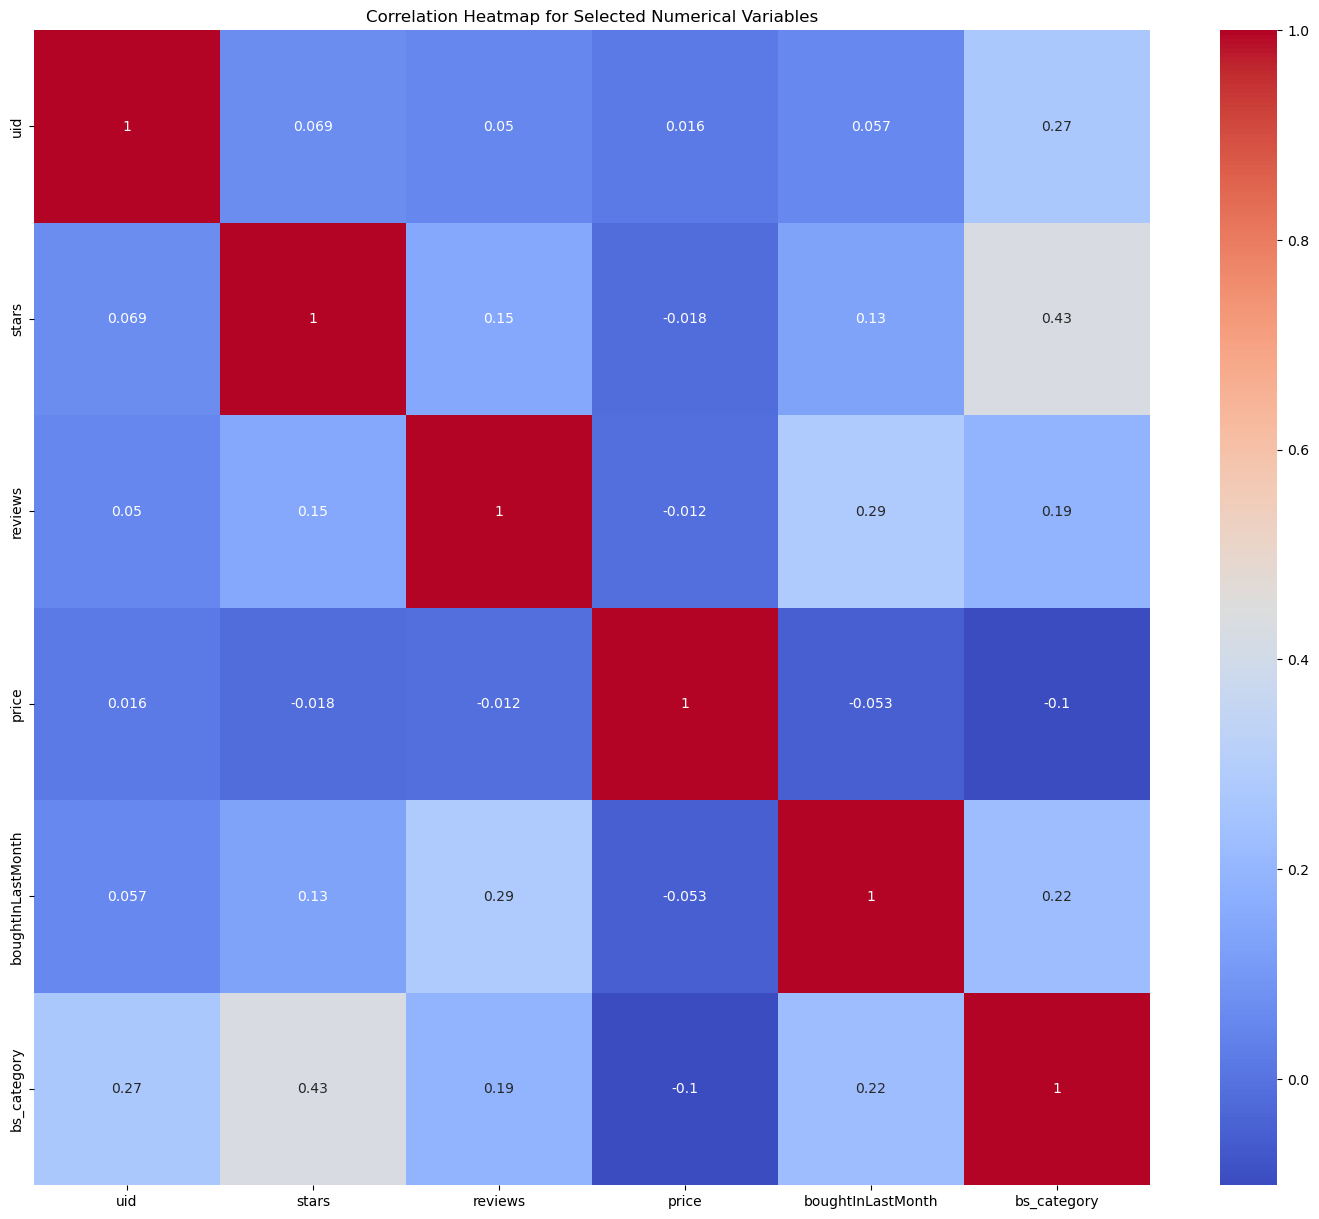

In [75]:
potential_categorical_from_numerical = filtered_data.select_dtypes("number").loc[:, filtered_data.select_dtypes("number").nunique() < 20]
df_numerical = filtered_data.select_dtypes("number").drop(columns=potential_categorical_from_numerical.columns)
correlation_matrix = df_numerical.corr()
# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))
# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

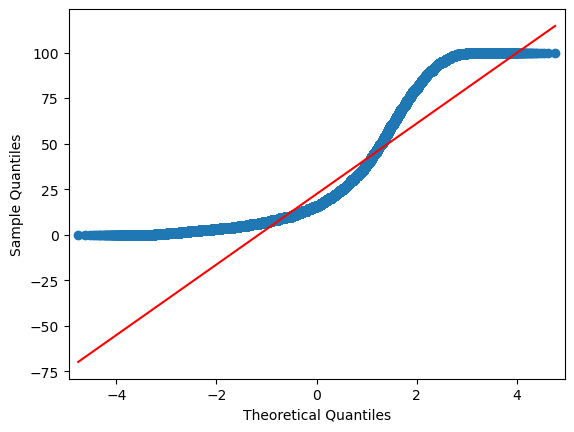

In [78]:
import statsmodels.api as sm
sm.qqplot(filtered_data['price'], line='s');